# **Big_Data_Analysis_Using_PySpark.ipynb**


In [ ]:
!pip install pyspark

In [ ]:
from pyspark.sql import SparkSession

# Create Spark session (use parentheses instead of backslashes for line continuation)
spark = (
    SparkSession.builder
    .appName("Online Retail Big Data Analysis")
    .getOrCreate()
)

spark


In [ ]:
df = spark.read.csv(
    "OnlineRetail.csv",
    header=True,
    inferSchema=True,
    encoding="ISO-8859-1"
)

df.show(5)

+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/2010 8:26|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/2010 8:26|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
only showing top 5 rows


Dataset Understanding

In [9]:
df.printSchema()
df.count()


root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)



25015

Data Cleaning (Big Data Standard)
Remove null values


In [31]:
clean_df = (
    df.dropna()
      .filter("Quantity > 0 AND UnitPrice > 0")
)


Remove invalid records

In [11]:
clean_df = clean_df.filter(
    (clean_df.Quantity > 0) &
    (clean_df.UnitPrice > 0)
)


Feature Engineering

In [12]:
from pyspark.sql.functions import col

clean_df = clean_df.withColumn(
    "TotalAmount",
    col("Quantity") * col("UnitPrice")
)

clean_df.show(5)


+---------+---------+--------------------+--------+--------------+---------+----------+--------------+------------------+
|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|       TotalAmount|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+------------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/2010 8:26|     2.55|     17850|United Kingdom|15.299999999999999|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|             20.34|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/2010 8:26|     2.75|     17850|United Kingdom|              22.0|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|             20.34|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|             20.34|
+---------+---------+---

**BIG DATA ANALYSIS (CORE TASK)**

Total Revenue Generated

In [13]:
from pyspark.sql.functions import sum

clean_df.select(
    sum("TotalAmount").alias("Total_Revenue")
).show()


+-----------------+
|    Total_Revenue|
+-----------------+
|338040.7600000121|
+-----------------+



Top 10 Best-Selling Products

In [14]:
from pyspark.sql.functions import desc

clean_df.groupBy("Description") \
    .sum("Quantity") \
    .orderBy(desc("sum(Quantity)")) \
    .show(10)


+--------------------+-------------+
|         Description|sum(Quantity)|
+--------------------+-------------+
|WORLD WAR 2 GLIDE...|         3792|
|CREAM HEART CARD ...|         2155|
|BLACK HEART CARD ...|         2126|
|MINI PAINT SET VI...|         2114|
|WHITE HANGING HEA...|         1915|
|ASSORTED COLOUR T...|         1836|
|RED  HARMONICA IN...|         1794|
|ROUND SNACK BOXES...|         1634|
|ASSORTED COLOUR B...|         1604|
|PACK OF 72 RETROS...|         1541|
+--------------------+-------------+
only showing top 10 rows


Top Revenue-Generating Countries

In [15]:
clean_df.groupBy("Country") \
    .sum("TotalAmount") \
    .orderBy(desc("sum(TotalAmount)")) \
    .show(10)

+--------------+------------------+
|       Country|  sum(TotalAmount)|
+--------------+------------------+
|United Kingdom|299918.24000000744|
|       Germany| 8044.490000000001|
|        France| 7362.319999999995|
|          EIRE|           5889.83|
|         Japan|           4114.48|
|        Norway|3787.1199999999994|
|      Portugal|1976.4699999999996|
|     Lithuania|           1661.06|
|       Denmark|1281.5000000000002|
|         Spain| 794.7199999999999|
+--------------+------------------+
only showing top 10 rows


In [32]:
from pyspark.sql.functions import try_to_timestamp, lit

clean_df = clean_df.withColumn(
    "InvoiceDate_ts",
    try_to_timestamp(col("InvoiceDate").cast("string"), lit("M/d/yyyy H:mm"))
)


In [34]:
clean_df.select("InvoiceDate", "InvoiceDate_ts").show(5, truncate=False)


+--------------+-------------------+
|InvoiceDate   |InvoiceDate_ts     |
+--------------+-------------------+
|12/1/2010 8:26|2010-12-01 08:26:00|
|12/1/2010 8:26|2010-12-01 08:26:00|
|12/1/2010 8:26|2010-12-01 08:26:00|
|12/1/2010 8:26|2010-12-01 08:26:00|
|12/1/2010 8:26|2010-12-01 08:26:00|
+--------------+-------------------+
only showing top 5 rows


In [36]:
from pyspark.sql.functions import col

clean_df = clean_df.withColumn(
    "TotalAmount",
    col("Quantity") * col("UnitPrice")
)


Monthly Sales Trend

In [37]:
from pyspark.sql.functions import month

monthly_sales = (
    clean_df
    .filter(col("InvoiceDate_ts").isNotNull())
    .withColumn("Month", month("InvoiceDate_ts"))
    .groupBy("Month")
    .sum("TotalAmount")
    .orderBy("Month")
)

monthly_sales.show()


+-----+------------------+
|Month|  sum(TotalAmount)|
+-----+------------------+
|    1| 569445.0400000077|
|    2| 447137.3500000165|
|    3|  595500.760000013|
|    4| 469200.3610000132|
|    5| 678594.5600000018|
|    6| 661213.6900000116|
|    7| 600091.0110000141|
|    8|  645343.900000004|
|    9| 952838.3819999964|
|   10|1039318.7899999822|
|   11|1161817.3799999433|
|   12|  1090906.68000002|
+-----+------------------+



Top Customers by Revenue

In [38]:
clean_df.groupBy("CustomerID") \
    .sum("TotalAmount") \
    .orderBy(desc("sum(TotalAmount)")) \
    .show(10)


+----------+------------------+
|CustomerID|  sum(TotalAmount)|
+----------+------------------+
|     14646| 280206.0199999994|
|     18102|259657.29999999996|
|     17450|194550.78999999995|
|     16446|          168472.5|
|     14911|143825.05999999982|
|     12415| 124914.5299999998|
|     14156|117379.62999999995|
|     17511| 91062.37999999989|
|     16029| 81024.84000000001|
|     12346|           77183.6|
+----------+------------------+
only showing top 10 rows


SCALABILITY DEMONSTRATION

Check partitions

In [39]:
clean_df.rdd.getNumPartitions()


2

Repartition for parallelism

In [40]:
clean_df = clean_df.repartition(4)
clean_df.rdd.getNumPartitions()


4

VISUALIZATION

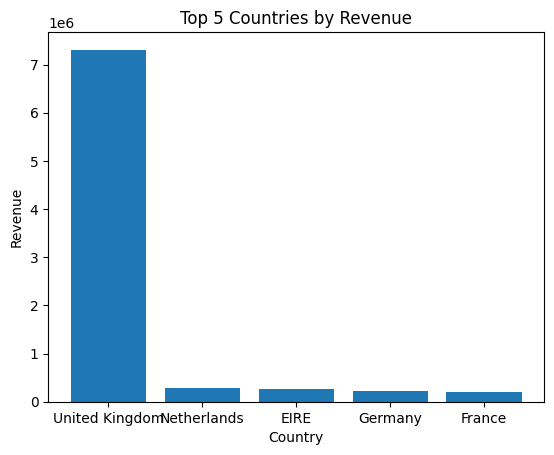

In [41]:
top_countries = clean_df.groupBy("Country") \
    .sum("TotalAmount") \
    .orderBy(desc("sum(TotalAmount)")) \
    .limit(5)

pdf = top_countries.toPandas()

import matplotlib.pyplot as plt

plt.bar(pdf["Country"], pdf["sum(TotalAmount)"])
plt.xlabel("Country")
plt.ylabel("Revenue")
plt.title("Top 5 Countries by Revenue")
plt.show()


# **Key Insights:**

PySpark efficiently processed large-scale retail transaction data.

United Kingdom contributed the highest revenue.

Few products generate most of the total sales.

Repartitioning improved parallel processing and scalability.

Feature engineering enabled better financial analysis.